# **Brain Tumor Segmentation and Classification**

##[Table Of Contents](#scrollTo=8T_ecJBW424A)

>[1. Initial Setup](#scrollTo=uTM6ykhI44qt)

>[2. Preprocessing](#scrollTo=z7g137-I478t)

>>[2.1. Creating the Datasets](#scrollTo=cd68cf37)

>>[2.2. Visualizing Instances](#scrollTo=uClYKkV15XA2)

>[3. Machine Learning](#scrollTo=Jn1psqiC5cyA)

>>[3.1. Training Process](#scrollTo=a01LzAeO5iLV)

>[4. Analyzing Results](#scrollTo=6b534df0)

>>[Losses](#scrollTo=jdPkLeqcBCA4)

>>[Learning Rate](#scrollTo=rCulIQnbBGk2)

>>[mAP](#scrollTo=2ac28vZnBJGi)

>>[mAP - Area](#scrollTo=ofeXRCWCBMzg)

>>[Recall](#scrollTo=WhkbJArnBRne)

>>[Recall - Area](#scrollTo=tP5qVTApBQGX)

>>[4.1. Prediction Testing](#scrollTo=ee41aa19)



# **1. Initial Setup**

- Downloading the dataset from Google Drive;

- Defining some constants;

- Mapping classes.

In [1]:
!pip install --upgrade -q gdown

from warnings import filterwarnings
from gdown    import download
from os.path  import isdir
from os       import (getcwd,
                      mkdir)

output_file = 'dataset.zip'
file_id = '18cPvbZrH5CUWhhIGZOSkiBSnCA0GPC1z'
download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=True)

!unzip -o -q ./{output_file} -d .

filterwarnings('ignore')

# Figures export directory
if not isdir(f'{getcwd()}/plots'):
    mkdir(f'{getcwd()}/plots')

In [2]:
BATCH_SIZE = 32
BBOX_FORMAT = 'xyxy'

In [3]:
class_ids = ['Glioma', 'Meningioma', 'Metastatic']
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'Glioma', 1: 'Meningioma', 2: 'Metastatic'}

# **2. Preprocessing**

- Parsing each _.txt_ file containing the tumours locations and its type (if it is present);

- Arrange each image in tensors, containing the image path, tumours types and its locations;

- Necessary steps for feeding the machine learning model.

In [4]:
import cv2 as cv


def parse_txt_label(img_path: str, txt_path: str) -> tuple[list, list]:

    img = cv.imread(img_path)
    width, height = img.shape[0], img.shape[1]

    instance_file = open(txt_path, 'r')
    lines = instance_file.read().split('\n')

    boxes, classes = list(), list()

    # No tumour case
    if not lines[0]:
        return classes, boxes
    else:
        for line in lines:

            # Structure for each line in txt file: <label> <x1> <y1> <x2> <y2>
            tumour = line.split(' ')
            label = int(tumour[0])

            # Box upper left vertex (x1, y1) and lower right vertex (x2, y2)
            x1 = float(tumour[1])
            y1 = float(tumour[2])
            x2 = float(tumour[3])
            y2 = float(tumour[4])

            # Coords are normalized between [0, 1], needs conversion
            xmin = int((x1 * width) - (x2 * width) / 2.0)
            ymin = int((y1 * height) - (y2 * height) / 2.0)
            xmax = int((x1 * width) + (x2 * width) / 2.0)
            ymax = int((y1 * height) + (y2 * height) / 2.0)

            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(label)

    return classes, boxes

In [5]:
from os.path import join
from os      import listdir
import tensorflow as tf


def arranging_files(img_files_path: str, label_files_path: str) -> tuple[list, list, list]:

    img_list = listdir(img_files_path)
    image_paths, bounding_box, classes = list(), list(), list()

    for img_file in img_list:

        labels, bbox = parse_txt_label(img_path=f'{img_files_path}/{img_file}',
                                       txt_path=f'{label_files_path}/{img_file.replace(".jpg", ".txt")}')

        image_paths.append(join(img_files_path, img_file))
        classes.append(labels)
        bounding_box.append(bbox)

    # Constructs RaggedTensors from nested Python lists
    image_paths = tf.ragged.constant(image_paths)
    bounding_box = tf.ragged.constant(bounding_box)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bounding_box

In [6]:
train_img_paths, train_classes, train_bboxes = arranging_files(img_files_path='Brain Tumor Detection/train/images',
                                                               label_files_path='Brain Tumor Detection/train/labels')

valid_img_paths, valid_classes, valid_bboxes = arranging_files(img_files_path='Brain Tumor Detection/valid/images',
                                                               label_files_path='Brain Tumor Detection/valid/labels')

test_img_paths, test_classes, test_bboxes = arranging_files(img_files_path='Brain Tumor Detection/test/images',
                                                            label_files_path='Brain Tumor Detection/test/labels')

## **2.1. Creating the Datasets**

In [7]:
def img_preprocessing(img_path):

    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)

    return img


def load_dataset(img_paths, classes, bbox):

    img = img_preprocessing(img_paths)

    bounding_boxes = {'classes': tf.cast(classes, dtype=tf.float32),
                      'boxes': bbox }

    return {'images': img, 'bounding_boxes': bounding_boxes}


def dict_to_tuple(inputs):
    return inputs['images'], inputs['bounding_boxes']

- Until now, YOLO only accepts images with dimensions above 128 and that are multiple of 64 (need to investigate more about this);

- No augmentation is being applied for now, just drafting some random noise introduction in the training dataset:
    - Scaling the resolution of images from [(128, 128), (192, 192)];

    - Applying horizontal mirrowing;

    - Lowering and raising constrast;

    - Lowering and raising brightness.

- The datasets pass the following stages:
    - Loading the images, tumour classes its locations in sliced tensors;
    
    - Creation of batches (32 images each);
    
    - Resizing images maintaining aspect ratio.

- The training dataset is also shuffled and can pass through some augmenting layers to introduce noise, aiming to reduce overfitting.


In [8]:
!pip install -q keras_cv

from keras import Sequential
from keras_cv.layers import (JitteredResize,
                             Resizing,
                             RandomFlip,
                             RandomContrast,
                             RandomBrightness)


# Option for automatically define best level of parallelism and dataset processing
AUTO = tf.data.AUTOTUNE

# Resizes all images maintaining aspect ratio (no flattening or stretching)
resizing = Resizing(height=192, width=192, pad_to_aspect_ratio=True,
                    bounding_box_format=BBOX_FORMAT)

# Augmenting layers to perform data augmentation on the dataset
# PS: If using this, apply only on the training set
augmenter = Sequential(
    layers=[
        JitteredResize(target_size=(128, 128), scale_factor=(1, 1.5), bounding_box_format=BBOX_FORMAT),
        RandomFlip(mode='horizontal', bounding_box_format=BBOX_FORMAT),
        RandomContrast(factor=0.5, value_range=[0.0, 255.0]),
        RandomBrightness(factor=0.5, value_range=[0.0, 255.0])
    ]
)

# Arranges the data in tensor slices (necessary for inputing the model)
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))

# Loads all data, shuffles it, make batches and resizes the images
train_dataset = (train_loader
                 .map(load_dataset, num_parallel_calls=AUTO)
                 .shuffle(len(list(train_loader.as_numpy_iterator())))
                 .ragged_batch(BATCH_SIZE)
                #  .map(augmenter,num_parallel_calls=tf.data.AUTOTUNE)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))

valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_dataset, num_parallel_calls=AUTO)
                 .ragged_batch(BATCH_SIZE)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_dataset, num_parallel_calls=AUTO)
                .ragged_batch(BATCH_SIZE)
                .map(resizing, num_parallel_calls=AUTO)
                .map(dict_to_tuple, num_parallel_calls=AUTO)
                .prefetch(AUTO))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.8 MB/s eta 0:00:00
Using TensorFlow backend


## **2.2. Visualizing Instances**

In [9]:
from keras_cv.visualization import plot_bounding_box_gallery


# Visualize example images along wih classes and boxes
def visualize_dataset(inputs: any, value_range: tuple, rows: int, cols: int, bounding_box_format: str) -> None:

    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    plot_bounding_box_gallery(images, value_range=value_range,
                              rows=rows, cols=cols,
                              y_true=bounding_boxes, scale=4,
                              font_scale=0.8, line_thickness=2,
                              dpi=100, bounding_box_format=bounding_box_format,
                              class_mapping=class_mapping,
                              true_color=(192, 57, 43))

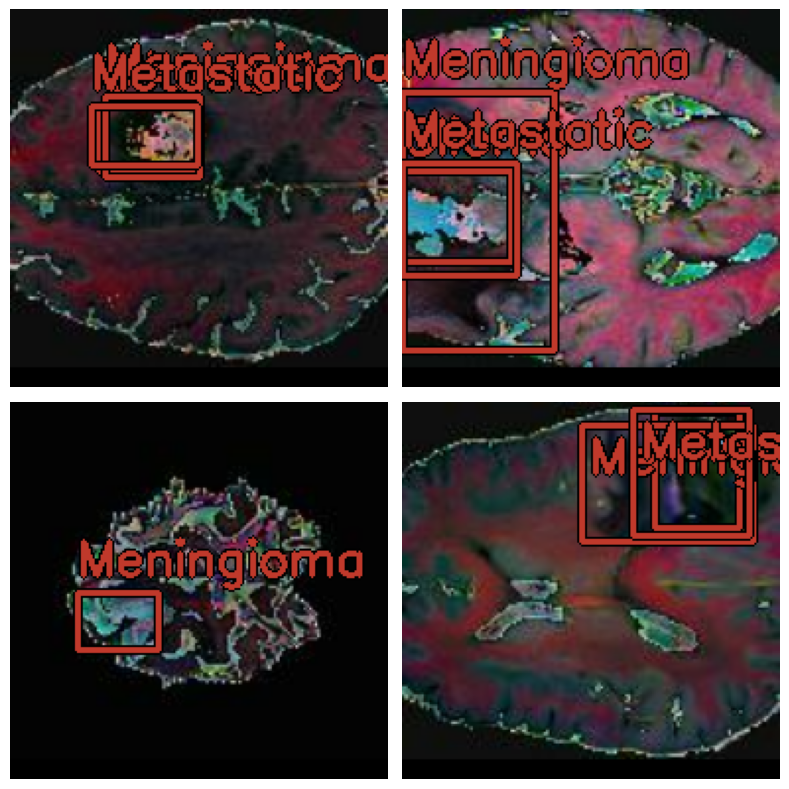

In [10]:
visualize_dataset(inputs=train_dataset, value_range=(0, 255), rows=2, cols=2, bounding_box_format=BBOX_FORMAT)

# **3. Machine Learning**

- We're using the YOLOv8 detector model with a backbone pre-trained on COCO (large dataset for object detection, segmentation, ...);

- The optimizer only has the _global\_clipnorm_ parameter specified, a keras_cv recommendation for building object detection models (problems with vanishing
and exploding gradients destabilizing training process);

- For more information on keras_cv models click [here](https://keras.io/api/keras_cv/models/), and for information about optimizers in object detection click [here](https://keras.io/guides/keras_cv/object_detection_keras_cv/#optimizer);

- The default detection metric used to evaluate the model is CIoU.

In [11]:
from keras.optimizers import AdamW
from keras_cv.models  import (YOLOV8Backbone,
                              YOLOV8Detector)


# Strategy typically used for training on one machine with multiple GPUs.
stg = tf.distribute.MirroredStrategy()

with stg.scope():

    backbone = YOLOV8Backbone.from_preset('yolo_v8_xs_backbone_coco')

    yolo_model = YOLOV8Detector(num_classes=len(class_mapping),
                                bounding_box_format=BBOX_FORMAT,
                                backbone=backbone, fpn_depth=1)

    optimizer = AdamW(#learning_rate=0.0001, weight_decay=0.004,
                      global_clipnorm=10)

    yolo_model.compile(optimizer=optimizer, classification_loss='binary_crossentropy', box_loss='ciou')

100%|██████████| 645/645 [00:00<00:00, 505kB/s]
100%|██████████| 5.11M/5.11M [00:00<00:00, 11.4MB/s]


## **3.1. Training Process**

- We're using several callbacks to optimize training:
    - **EarlyStopping**: Stops the training if after a number of epochs the model doesn't improve;

    - **ReduceLROnPlateau**: Reduces learning rate by a percentual if after a number of epochs the model doesn't improve;

    - **BackupAndRestore**: Saves training process to resume later in cause of abrupt interruption.

- We're using a custom callback to get other metrics (COCO), such as mAP;

- The number of epochs still need some study.

In [14]:
from keras_cv.metrics import BoxCOCOMetrics
from keras.callbacks  import Callback


class EvaluateCOCOMetricsCallback(Callback):

    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = BoxCOCOMetrics(bounding_box_format=BBOX_FORMAT, evaluate_freq=1e9)
        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):

        self.metrics.reset_state()

        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics['MaP']
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [12]:
from keras.callbacks import (ReduceLROnPlateau,
                             BackupAndRestore,
                             EarlyStopping)


# Decreases learning rate by half after each 3 epochs passed and no improvement was made
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=3, verbose=1, mode='min',
                                            min_lr=0.00001)

# Stop training if after 5 epochs passed no improvement was made
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           mode='min', restore_best_weights=True)

# Saves the training state at the end of each epoch to restore later in case of abrupt interruption
if not isdir(f'{getcwd()}/backups'):
    mkdir(f'{getcwd()}/backups')
backup = BackupAndRestore(f'{getcwd()}/backups', save_freq='epoch')

In [13]:
# PS: Careful with RAM usage using backup and coco callbacks

use_coco = False

if use_coco:
    hist = yolo_model.fit(train_dataset, validation_data=valid_dataset, epochs=50,
                          callbacks=[learning_rate_reduction, early_stop,
                                    EvaluateCOCOMetricsCallback(valid_dataset, 'model.tf')
                                    # backup
                                    ])
else:
    hist = yolo_model.fit(train_dataset, validation_data=valid_dataset, epochs=50,
                          callbacks=[learning_rate_reduction, early_stop
                                     #backup, EvaluateCOCOMetricsCallback(valid_dataset, 'model.tf'),
                                    ])

Epoch 1/50
217/217 [==============================] - 96s 164ms/step - loss: 18.8681 - box_loss: 2.4778 - class_loss: 16.3904 - val_loss: 3.6316 - val_box_loss: 2.0585 - val_class_loss: 1.5732 - lr: 0.0010
Epoch 2/50
217/217 [==============================] - 37s 160ms/step - loss: 3.0168 - box_loss: 1.9645 - class_loss: 1.0523 - val_loss: 2.9293 - val_box_loss: 1.9871 - val_class_loss: 0.9421 - lr: 0.0010
Epoch 3/50
217/217 [==============================] - 32s 141ms/step - loss: 2.5573 - box_loss: 1.8649 - class_loss: 0.6924 - val_loss: 2.5049 - val_box_loss: 1.8718 - val_class_loss: 0.6331 - lr: 0.0010
Epoch 4/50
217/217 [==============================] - 31s 136ms/step - loss: 2.3534 - box_loss: 1.7736 - class_loss: 0.5798 - val_loss: 2.3503 - val_box_loss: 1.7820 - val_class_loss: 0.5683 - lr: 0.0010
Epoch 5/50
217/217 [==============================] - 30s 132ms/step - loss: 2.2085 - box_loss: 1.6883 - class_loss: 0.5202 - val_loss: 2.3614 - val_box_loss: 1.8218 - val_class_loss

In [14]:
import numpy as np


model_path = f'{getcwd()}/yolo_tmp.keras'
yolo_model.save(model_path)

history_path = f'{getcwd()}/history_tmp.keras'
np.save(history_path, hist.history)

# **4. Analyzing Results**

In [ ]:
if 'hist' not in locals():
  hist = np.load(history_path, allow_pickle='TRUE').item()

## **Losses**

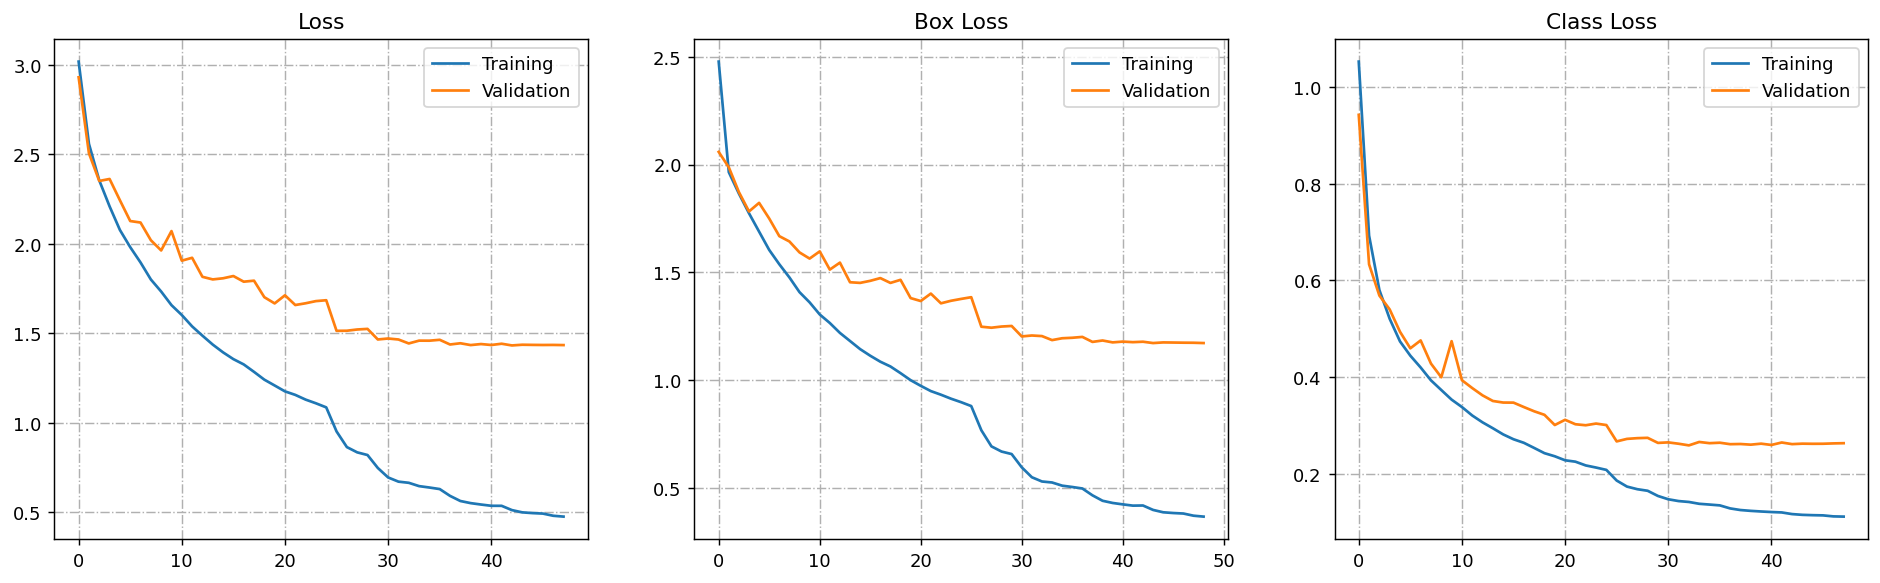

In [15]:
import matplotlib.pyplot as plt


fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs1[0].grid(linestyle='dashdot')
axs1[0].set_title('Loss')
axs1[0].plot(hist.history['loss'][1:])
axs1[0].plot(hist.history['val_loss'][1:])
axs1[0].legend(['Training', 'Validation'])

axs1[1].grid(linestyle='dashdot')
axs1[1].set_title('Box Loss')
axs1[1].plot(hist.history['box_loss'])
axs1[1].plot(hist.history['val_box_loss'])
axs1[1].legend(['Training', 'Validation'])

axs1[2].grid(linestyle='dashdot')
axs1[2].set_title('Class Loss')
axs1[2].plot(hist.history['class_loss'][1:])
axs1[2].plot(hist.history['val_class_loss'][1:])
axs1[2].legend(['Training', 'Validation'])

plt.savefig(f'{getcwd()}/plots/std_distribution.png', format='png')
plt.show()

## **Learning Rate**

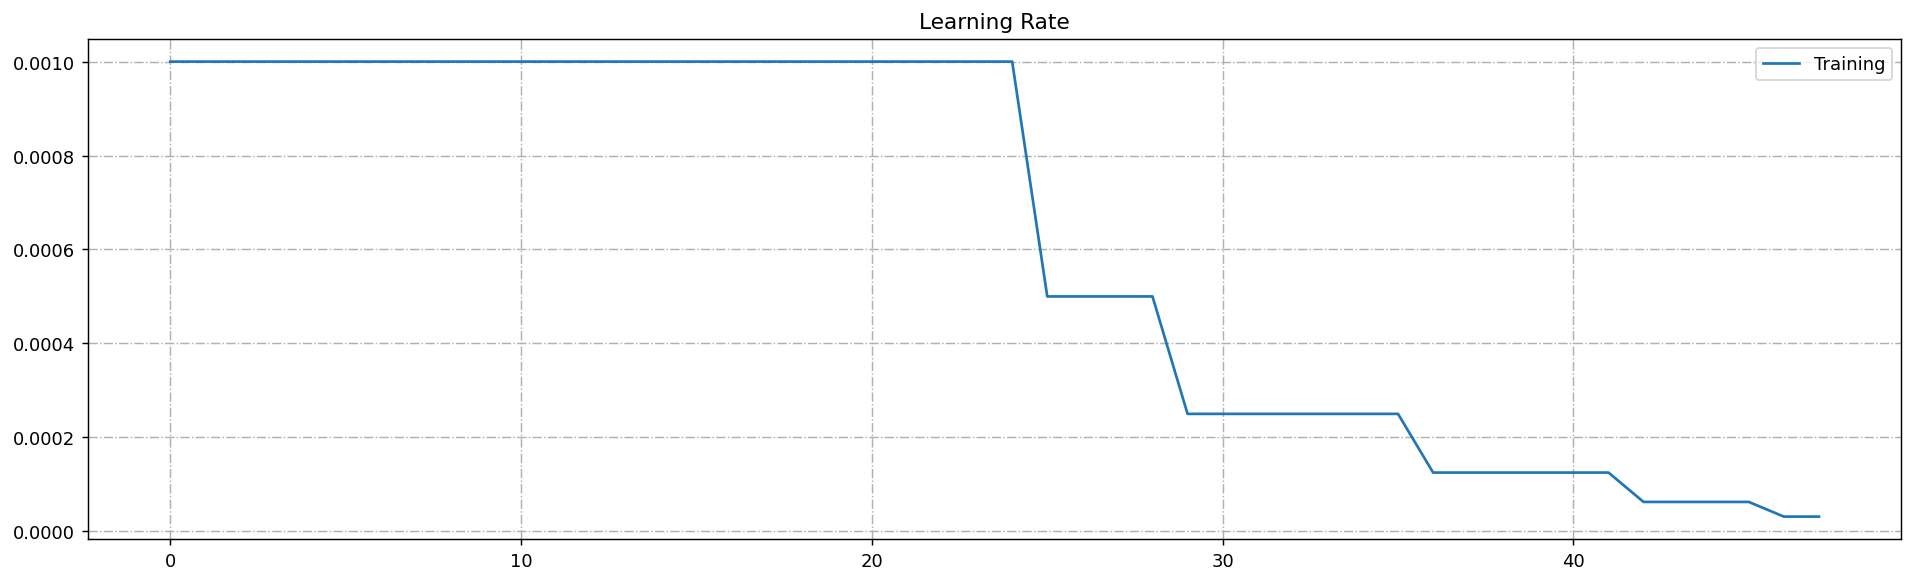

In [16]:
fig2, axs2 = plt.subplots(1, 1, figsize=(18, 5), dpi=130)

axs2.grid(linestyle='dashdot')
axs2.set_title('Learning Rate')
axs2.plot(hist.history['lr'][1:])
axs2.legend(['Training'])

plt.savefig(f'{getcwd()}/plots/learning_rate.png', format='png')
plt.show()

## **mAP**

In [ ]:
fig3, axs3 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs3[0].grid(linestyle='dashdot')
axs3[0].set_title('MaP')
axs3[0].plot(hist.history['MaP'][1:])
axs3[0].legend(['Training'])

axs3[1].grid(linestyle='dashdot')
axs3[1].set_title('MaP@[IoU=50]')
axs3[1].plot(hist.history['MaP'][1:])
axs3[1].legend(['Training'])

axs3[2].grid(linestyle='dashdot')
axs3[2].set_title('MaP@[IoU=75]')
axs3[2].plot(hist.history['MaP@[IoU=75]'][1:])
axs3[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/map.png', format='png')
plt.show()

## **mAP - Area**

In [ ]:
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs4[0].grid(linestyle='dashdot')
axs4[0].set_title('MaP@[area=small]')
axs4[0].plot(hist.history['MaP@[area=small]'][1:])
axs4[0].legend(['Training'])

axs4[1].grid(linestyle='dashdot')
axs4[1].set_title('MaP@[area=medium]')
axs4[1].plot(hist.history['MaP@[area=medium]'][1:])
axs4[1].legend(['Training'])

axs4[2].grid(linestyle='dashdot')
axs4[2].set_title('MaP@[area=large]')
axs4[2].plot(hist.history['MaP@[area=large]'][1:])
axs4[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/map_area.png', format='png')
plt.show()

## **Recall**

In [ ]:
fig5, axs5 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs5[0].grid(linestyle='dashdot')
axs5[0].set_title('Recall@[max_detections=1]')
axs5[0].plot(hist.history['Recall@[max_detections=1]'][1:])
axs5[0].legend(['Training'])

axs5[1].grid(linestyle='dashdot')
axs5[1].set_title('Recall@[max_detections=10]')
axs5[1].plot(hist.history['Recall@[max_detections=10]'][1:])
axs5[1].legend(['Training'])

axs5[2].grid(linestyle='dashdot')
axs5[2].set_title('Recall@[max_detections=100]')
axs5[2].plot(hist.history['Recall@[max_detections=100]'][1:])
axs5[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/recall.png', format='png')
plt.show()

## **Recall - Area**

In [ ]:
fig6, axs6 = plt.subplots(1, 3, figsize=(18, 5), dpi=130)

axs6[0].grid(linestyle='dashdot')
axs6[0].set_title('Recall@[area=small1]')
axs6[0].plot(hist.history['Recall@[area=small]'][1:])
axs6[0].legend(['Training'])

axs6[1].grid(linestyle='dashdot')
axs6[1].set_title('Recall@[area=medium]')
axs6[1].plot(hist.history['Recall@[area=medium]'][1:])
axs6[1].legend(['Training'])

axs6[2].grid(linestyle='dashdot')
axs6[2].set_title('Recall@[area=large]')
axs6[2].plot(hist.history['Recall@[area=large]'][1:])
axs6[2].legend(['Training'])

plt.savefig(f'{getcwd()}/plots/recall_area.png', format='png')
plt.show()

## **4.1. Prediction Testing**

In [ ]:
from keras.models import load_model


if 'yolo_model' not in locals():
    yolo_model = load_model(model_path)

In [17]:
def join_batches(batches):

    all_images = tf.concat([images for images, _ in batches], axis=0)
    all_classes = tf.concat([labels['classes'] for _, labels in batches], axis=0)
    all_boxes = tf.concat([labels['boxes'] for _, labels in batches], axis=0)

    return all_images, { 'classes': all_classes, 'boxes': all_boxes }

images, y_true = join_batches(batches=test_dataset.take(-1))

In [20]:
from keras_cv.bounding_box import to_ragged


y_pred = yolo_model.predict(images, verbose=0)
y_pred = to_ragged(y_pred)

In [21]:
def visualize_predict_detections(images, y_true, y_pred, cols: int, rows: int,
                                 bounding_box_format: str) -> None:

    print("############################# Padrão Ouro #############################")
    plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        true_color=(192, 57, 43),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=rows,
        cols=cols,
        show=True,
        class_mapping=class_mapping,
    )

    print("############################# Previsto #############################")
    plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=rows,
        cols=cols,
        show=True,
        class_mapping=class_mapping,
    )

    print("############################# Sobreposição #############################")
    plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color=(192, 57, 43),
        pred_color=(255, 235, 59),
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        rows=rows,
        cols=cols,
        show=True,
        class_mapping=class_mapping,
    )


def preview_labels(y_set, idx) -> dict:

    classes = tf.gather(y_set['classes'], idx)
    boxes = tf.gather(y_set['boxes'], idx)

    return { 'classes': classes, 'boxes': boxes }

############################# Padrão Ouro #############################


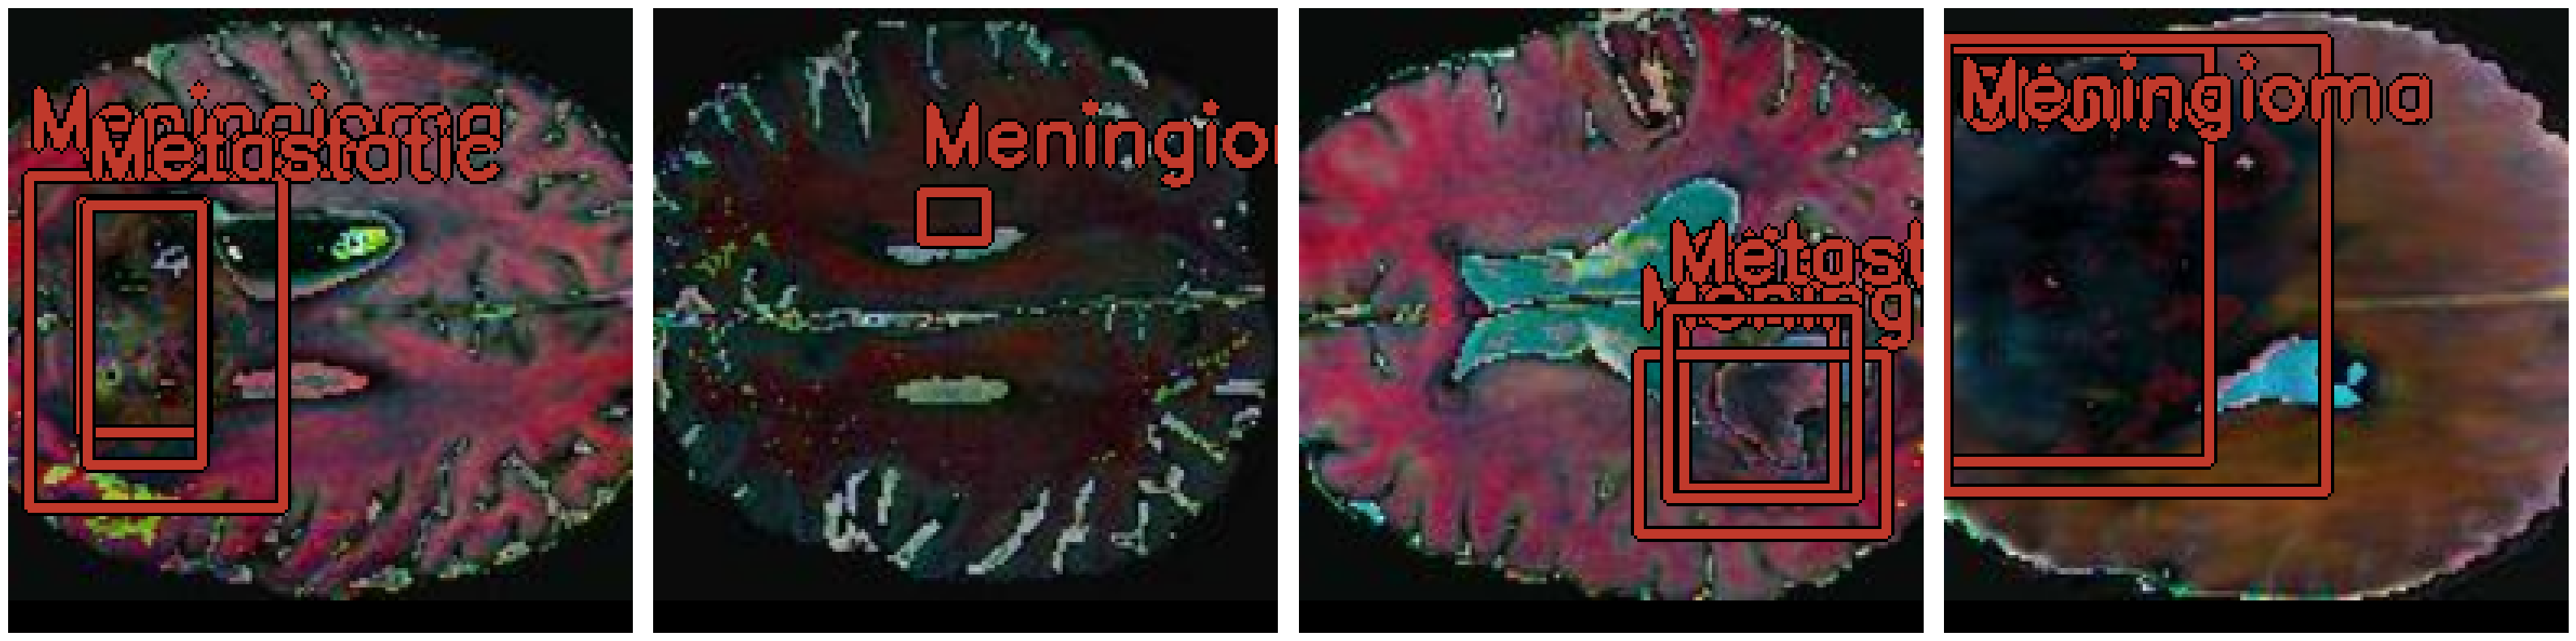

############################# Previsto #############################


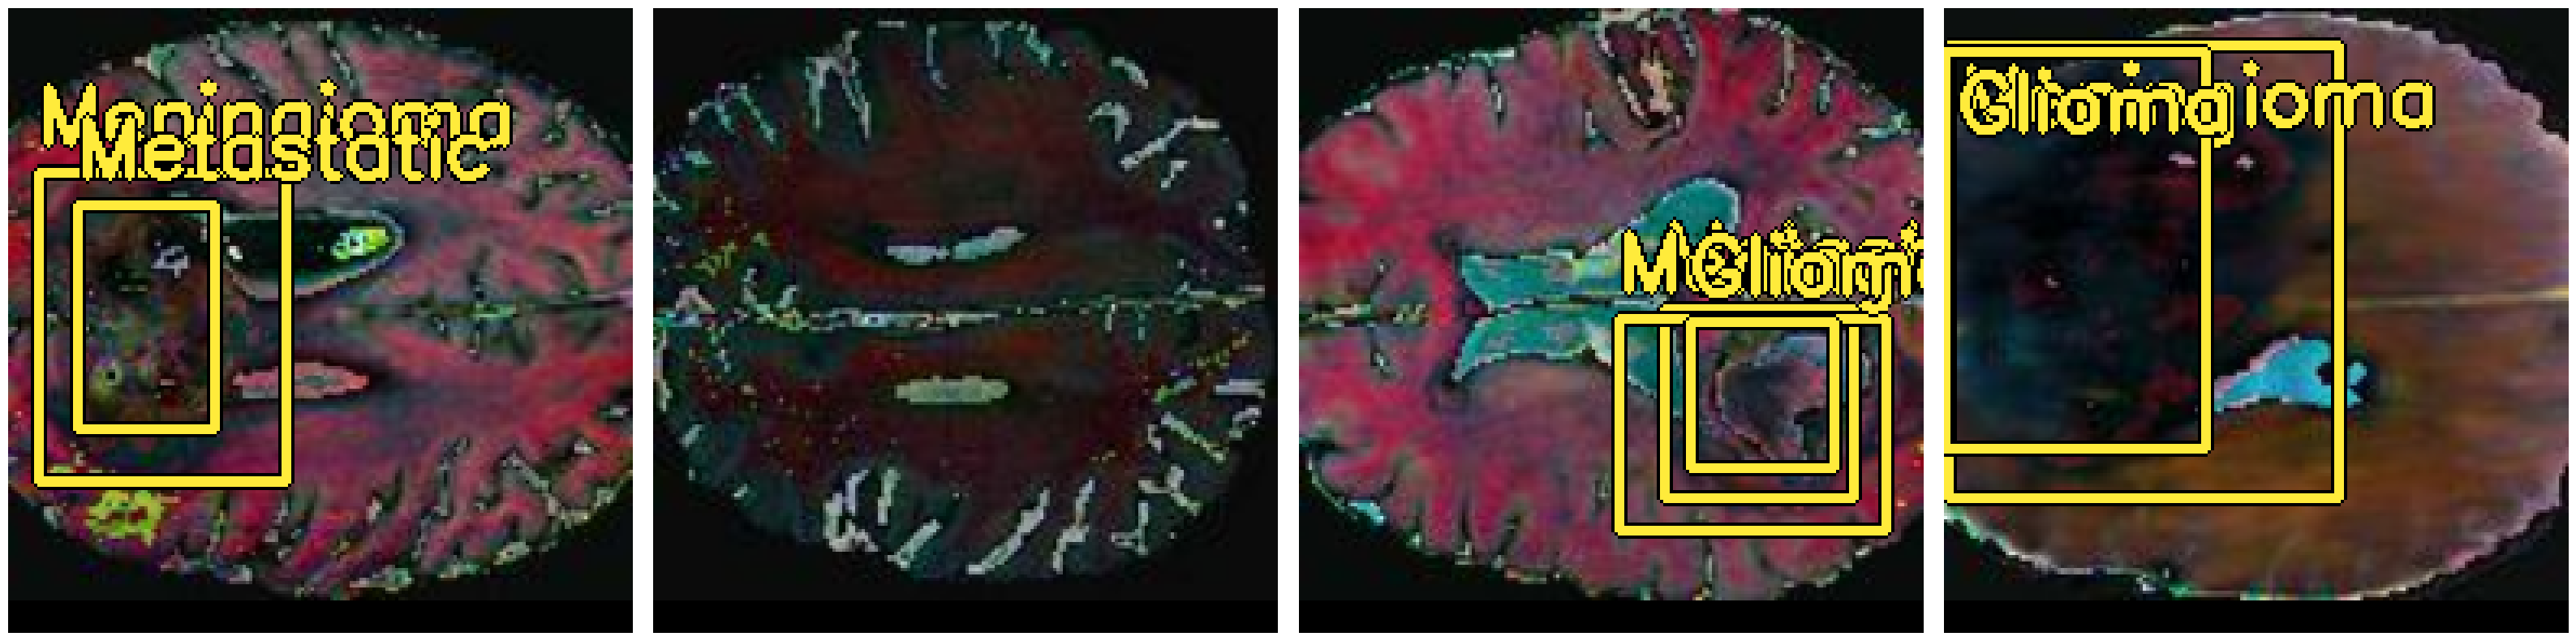

############################# Sobreposição #############################


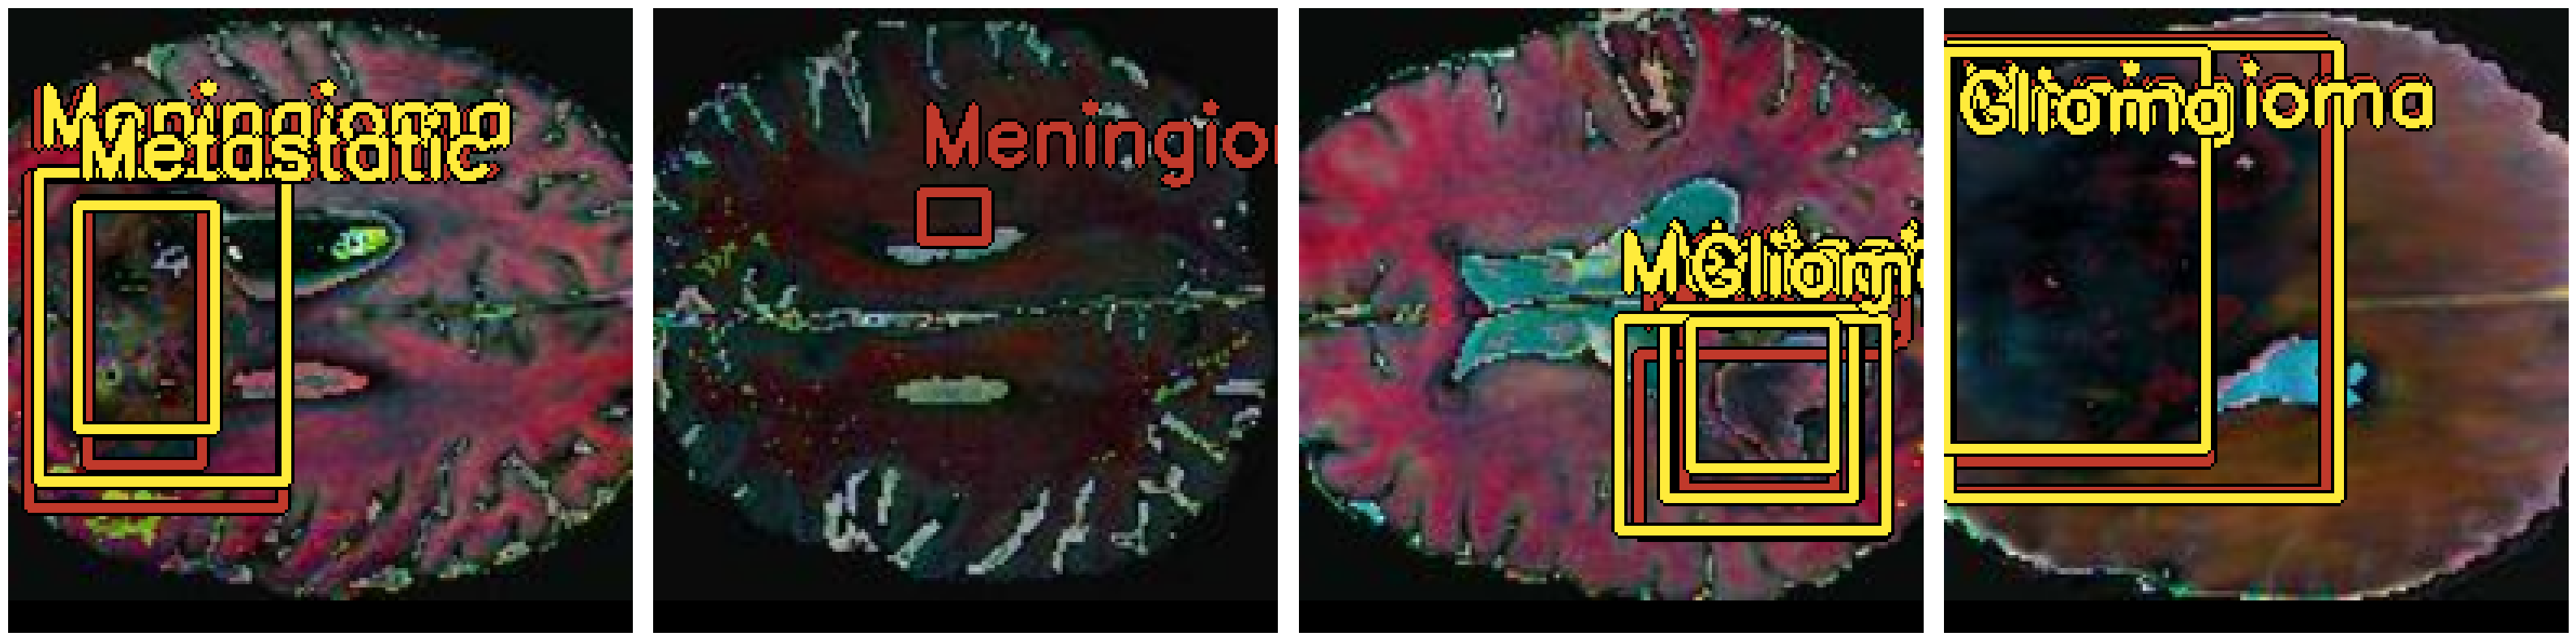

In [22]:
inicio = 10
fim = 20
rows = 1
cols = 4
idx = tf.constant(range(inicio, fim))

preview_images = tf.gather(images, idx)
preview_y_true = preview_labels(y_true, idx)
preview_y_pred = preview_labels(y_pred, idx)

visualize_predict_detections(preview_images, preview_y_true, preview_y_pred,
                             cols, rows, bounding_box_format=BBOX_FORMAT)